https://github.com/rfordatascience/tidytuesday/tree/master/data/2019/2019-02-19

In [1]:
using DataFrames, DataFramesMeta, CSV, Chain
ENV["COLUMNS"] = 1000;

In [2]:
df = CSV.read(
    download("https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2019/2019-02-19/phd_by_field.csv"),
    DataFrame
);

@chain df.n_phds begin
    replace!(missing => 0)
    replace!("NA"=> "0")
end;

df.n_phds = parse.(Int, df.n_phds);

In [3]:
using TimeSeries, Dates

# general EDA

In [4]:
gd = @chain df begin
    sort(["broad_field", "year"], rev=[false, false])
    groupby(["broad_field", "year"])
    combine(:n_phds => sum)
end;

In [5]:
groups = groupby(gd, "broad_field");

pct_groups = []

for group in groups
    slice =  DataFrame(group[!,["year", "n_phds_sum"]])
    slice.year = Date.(string.(slice.year), DateFormat("yyyy"))

    ta = TimeArray(slice, timestamp = :year)
    
    pct = DataFrame(percentchange(ta))
    
    pct.broad_field .= group.broad_field |> unique
    
    push!(pct_groups, pct)
end

In [6]:
pct = vcat(pct_groups...)[!, [:timestamp, :broad_field, :n_phds_sum]];

In [7]:
using PlotlyJS

WebIO._IJuliaInit()

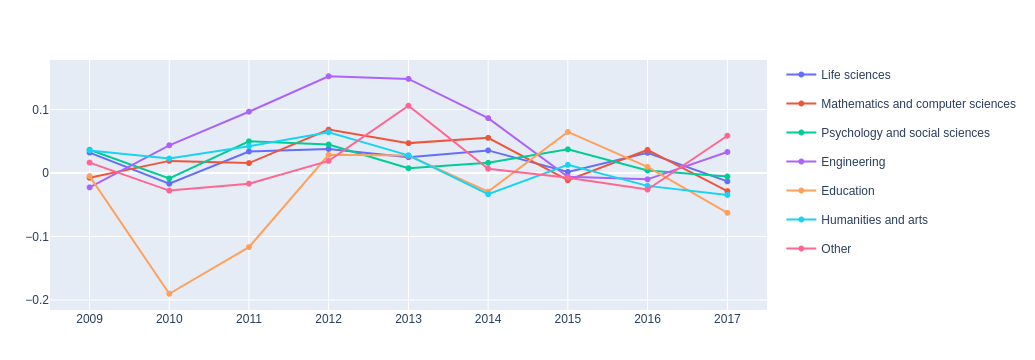

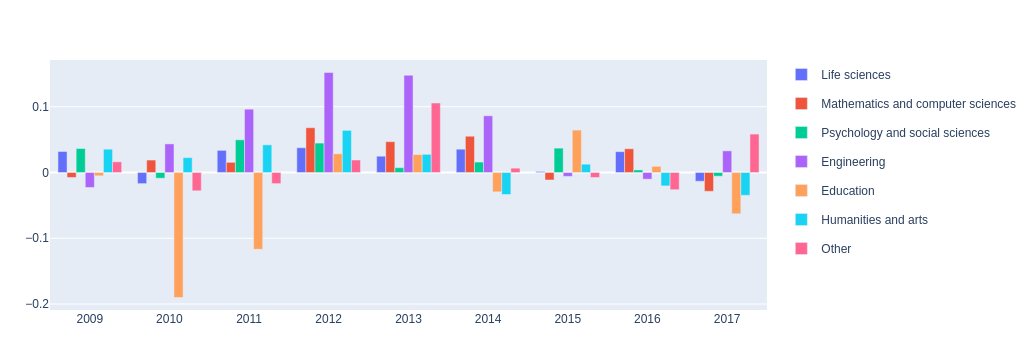

In [8]:
for func in [scatter, bar]
    plot(func(pct, x=:timestamp, y=:n_phds_sum, group=:broad_field)) |> display
end